In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import nltk
import seaborn as sns
from wordcloud import WordCloud

In [2]:
imdb = pd.read_csv("IMDB Dataset.csv")
imdb

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
imdb["sentiment"].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

First, we want to clean the data by converting text to lowercase, removing punctuations, implementing lemmatization, and removing stopwords.

In [4]:
imdb['review'] = imdb['review'].str.lower()
imdb

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,i am a catholic taught in parochial elementary...,negative
49998,i'm going to have to disagree with the previou...,negative


In [5]:
imdb['review'] = imdb['review'].str.replace('[^\w\s]','')
imdb

/var/folders/rj/dpbwchcx3tz4lk0s_qynk5fw0000gn/T/ipykernel_46374/2027496761.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  imdb['review'] = imdb['review'].str.replace('[^\w\s]','')


,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production br br the filmin...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,i am a catholic taught in parochial elementary...,negative
49998,im going to have to disagree with the previous...,negative


In [6]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    words = [lemmatizer.lemmatize(word,pos='v') for word in text.split()]
    return ' '.join(words)
imdb['review'] = imdb['review'].apply(lemmatize)

In [7]:
from nltk.corpus import stopwords
stopword = stopwords.words("English")
imdb['review'] = imdb["review"].apply(lambda x: " ".join(x for x in x.split() if x not in stopword))
imdb

,review,sentiment
0,one reviewers mention watch 1 oz episode youll...,positive
1,wonderful little production br br film techniq...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically theres family little boy jake think ...,negative
4,petter matteis love time money visually stun f...,positive
...,...,...
49995,think movie right good job wasnt creative orig...,positive
49996,bad plot bad dialogue bad act idiotic direct a...,negative
49997,catholic teach parochial elementary school nun...,negative
49998,im go disagree previous comment side maltin on...,negative


We will split the datasets into 80% training data and 20% test data. We also want to have approximately the same distribution of positive and negative reviews for both training and testing datasets.

In [8]:
imdb["random_num"] = np.random.random(len(imdb.index))
imdb_train = imdb[imdb["random_num"] <= 0.8]
imdb_test = imdb[imdb["random_num"] > 0.8]

In [9]:
imdb_train["sentiment"].value_counts()

negative    20007
positive    19906
Name: sentiment, dtype: int64

In [10]:
imdb_test["sentiment"].value_counts()

positive    5094
negative    4993
Name: sentiment, dtype: int64

Next, we will create a bag of words for the datasets

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(imdb_train["review"])
test_matrix = vectorizer.transform(imdb_test["review"])

Then we will apply the logistic regression model.

In [12]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X=train_matrix, y=imdb_train["sentiment"])

LogisticRegression(max_iter=500)


Now lets make predictions about the test data using the logistic regression model 

In [13]:
lr_predictions = lr_model.predict(test_matrix)

In [14]:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(imdb_test["sentiment"])
cf_matrix = confusion_matrix(lr_predictions,imdb_test["sentiment"])
cf_matrix

array([[4402,  516],
       [ 591, 4578]])

In [15]:
print(classification_report(lr_predictions,imdb_test["sentiment"], labels = ['positive','negative']))

              precision    recall  f1-score   support

    positive       0.90      0.89      0.89      5169
    negative       0.88      0.90      0.89      4918

    accuracy                           0.89     10087
   macro avg       0.89      0.89      0.89     10087
weighted avg       0.89      0.89      0.89     10087



We can visualize the result of the confusion matrix.

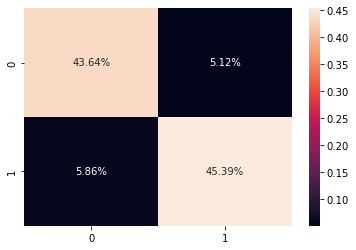

In [16]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%');